В качестве итогового подхода к данной задаче я решил использовать решение через непосредственно минимизацию целевой функции без каких-либо углублений в нюансы (такие как то, что на самом деле наш лосс это лосс для логистической регрессии и т.д.). В итоге нам просто нужно минимизировать функцию потерь до требуемого уровня, а затем написать функции для оценивания на новых входных данных.
Из особенностей данных здесь можно заметить, что гистограммы значений признаков имеют так называемую ассиметрию (skewness), в нашем случае мы видим оба типа ассиметри, а именно положительную и отрицательную. [По этой ссылке](https://www.kaggle.com/code/setu06/handling-with-highly-skewed-data-set) можно почитать о том что это такое и как с этим бороться, также в интернете много статей по этому поводу.
Для себя я выбрал логарифмирование и возведение в степень, чтобы избавиться от ассиметрии.
Также данные были нормированы по аналогии с StandardScaler из библиотеки sklearn. (Думаю можно использовать и непосредственно его, но мне было удобнее своими силами написать, благо формула тривиальная)


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_table('restaurants_train.txt',header=None)

In [28]:
df = df.rename({0:'y',
                    1:'r1',
                    2:'r2',
                    3:'d1',
                    4:'d2'},axis=1)

In [29]:
r_mean = df[(df['r1']!=-1)&(df['r2']!=-1)][['r1','r2']].values.mean()

df.r1 = np.where(df.r1==-1,r_mean,df.r1)
df.r2 = np.where(df.r2==-1,r_mean,df.r2)

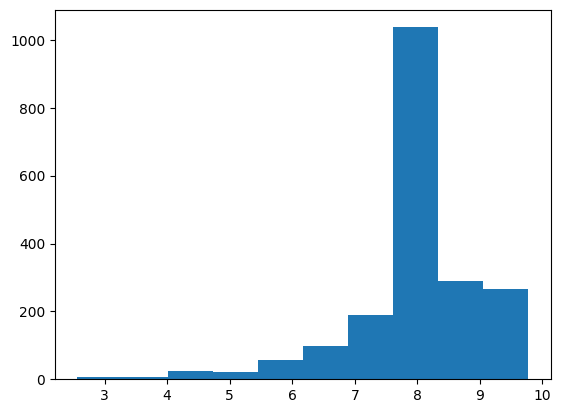

In [30]:
plt.hist(df[['r1','r2']].values.reshape(-1,1))
plt.show()

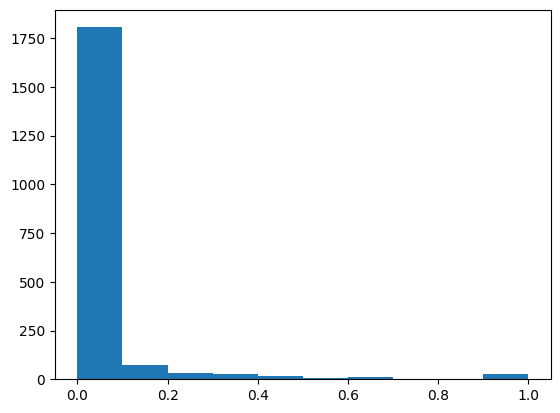

In [31]:
plt.hist(df[['d1','d2']].values.reshape(-1,1))
plt.show()

In [32]:
df['d1'] = np.log(df.d1+0.00001)
df.d2 = np.log(df.d2+0.00001)
df.r1 = df.r1**2
df.r2 = df.r2**2

In [33]:
r_exp_mean = df[['r1', 'r2']].values.mean()
r_exp_std = df[['r1', 'r2']].values.std()
d_log_mean = df[['d1', 'd2']].values.mean()
d_log_std = df[['d1', 'd2']].values.std()
df['r1'], df['r2'] = (df['r1'] - r_exp_mean) / r_exp_std, (df['r2'] - r_exp_mean) / r_exp_std
df['d1'], df['d2'] = (df['d1'] - d_log_mean) / d_log_std, (df['d2'] - d_log_mean) / d_log_std
df['r_diff'] = df['r1'] - df['r2']
df['d_diff'] = df['d1'] - df['d2']

In [34]:
r_mean

8.045780581601162

In [35]:
r_exp_mean

64.8234762774463

In [36]:
r_exp_std

14.65390225004166

In [37]:
d_log_mean

-4.569731300663472

In [38]:
d_log_std

1.583048315334561

In [39]:
def to_minimize(w_params):
    w = np.array(w_params)
    df['s1'] = df[['r1', 'd1']] @ w
    df['s2'] = df[['r2', 'd2']] @ w
    df['s_diff'] = df['s1'] - df['s2']
    return pd.concat((np.log(1 + np.exp(df[df['y'] == 0]['s2'] - df[df['y'] == 0]['s1'])),
               np.log(1 + np.exp(df[df['y'] == 1]['s1'] - df[df['y'] == 1]['s2'])))).mean()

In [40]:
from scipy.optimize import minimize


res = minimize(to_minimize,[1,1])

In [41]:
w = res.x

In [42]:
w

array([ 0.54223411, -1.81215978])

Финальный код для решения задачи

In [ ]:
import sys
import math

n = int(sys.stdin.readline())

for _ in range(n):
    r, d = map(float, sys.stdin.readline().split())
    if r==-1:
        r = 8.045780581601162
    r = (math.exp(r) - 4214.130194409842) / 3339.7772021621736
    d = (math.log(d + 0.0001) + 4.569731300663472) / 1.583048315334561
    b0 = 0
    b1 = 0.542234
    b2 = -1.812160
    print((b0 + r * b1 + d * b2))